# Tests on sequences of data from AirSim

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from scipy.spatial.transform import Rotation as R

import planeslam.io as io
from planeslam.extraction import pc_to_planes
from planeslam.scan import pc_to_scan

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract scans from LiDAR point clouds

In [4]:
# Extract scans and planesets
num_scans = len(PC_data)
scans = num_scans * [None]
planesets = num_scans * [None]

for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])
    r = R.from_quat(drone_orientations[i,:])
    scans[i].transform(r.as_matrix(), drone_positions[i,:])

    # planesets[i] = pc_to_planes(PC_data[i])
    # for p in planesets[i]:
    #     r = R.from_quat(drone_orientations[i,:])
    #     p.transform(r.as_matrix(), drone_positions[i,:])

Merge Scans

In [5]:
merge = scans[0].merge(scans[1])

vertex and face generation not yet implemented


In [ ]:
# Plot merge
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
colors = ['r', 'b']

for i, scan in enumerate(scans[0:2]):
    scan.plot(ax, color=colors[i], show_normal=True)

merge.plot(ax, color='m', show_normal=True)

ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

KeyboardInterrupt: 

In [10]:
merged = planesets[0]

for ps in planesets[1:]:
    merged = merge_scans(merged, ps)

Text(0.5, 0.5, 'Y')

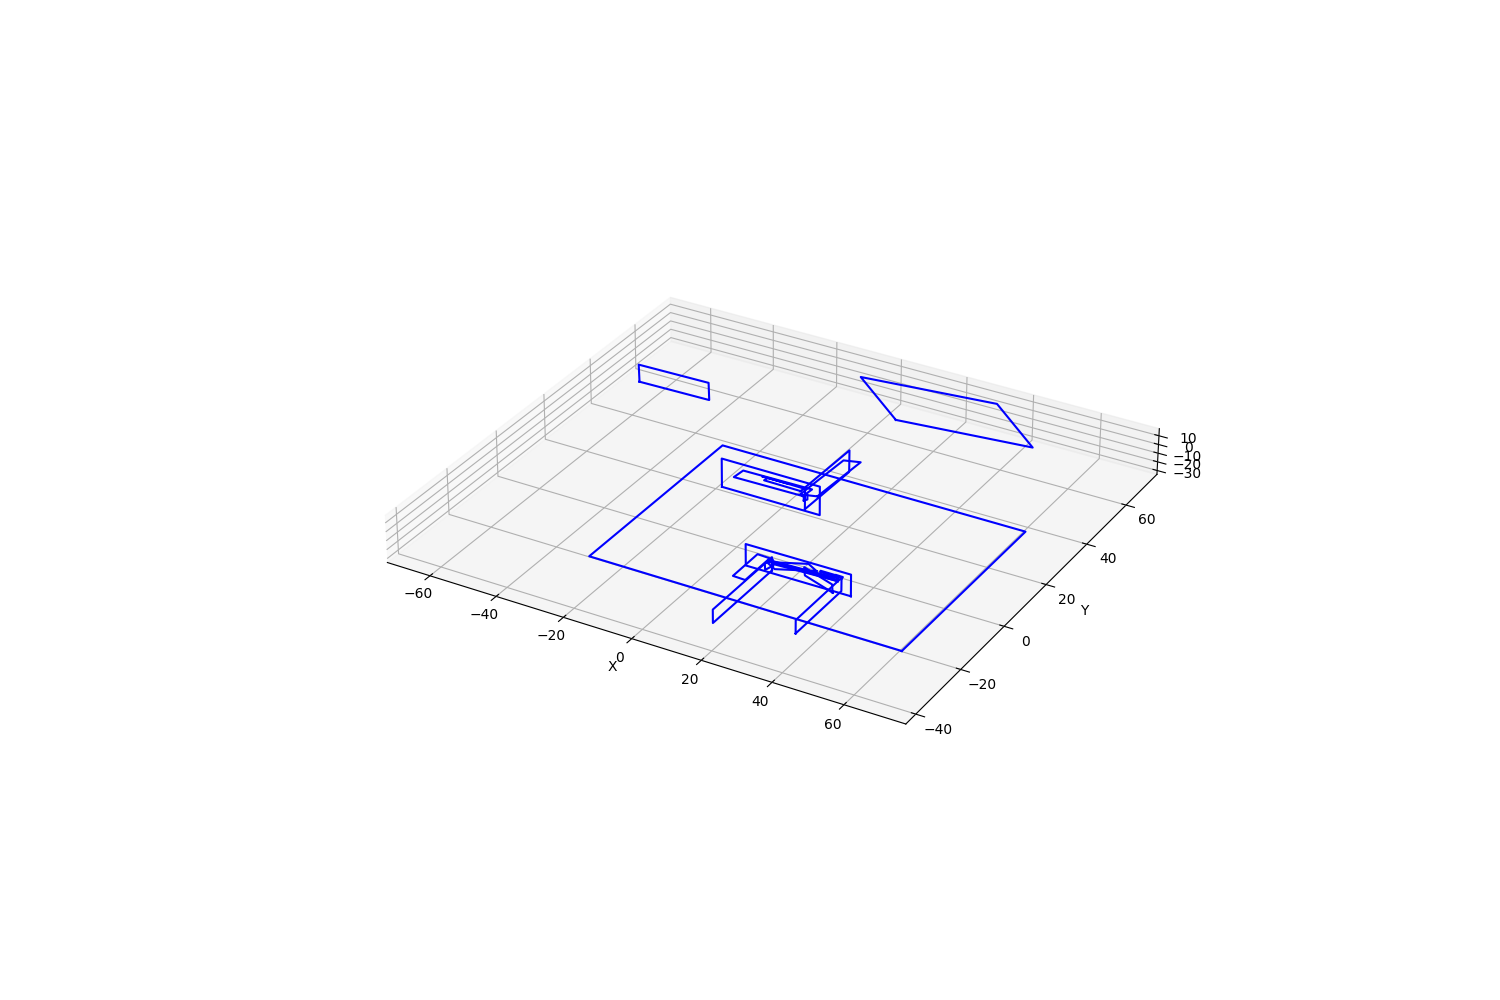

In [11]:
# Plot merge
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for p in merged:
    p.plot(ax)

ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")